# Implementation of $[[n, k, d]]$ codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, Statevector, Kraus, SuperOp
from qiskit.quantum_info import hellinger_fidelity, state_fidelity
from qiskit_ibm_provider import IBMProvider, least_busy

from qiskit.result import marginal_counts
from qiskit.tools.monitor import job_monitor

In [2]:
np.random.seed(42)

#### $[[5, 1, 3]]$ code 

Stabilizers - 

$Z X X Z I, I Z X X Z, Z I Z X X, X Z I Z X$

In [3]:
qdata_register = QuantumRegister(5, name="data")
stabilizer_measure_reg = QuantumRegister(4, name="anc")
syndrome_measure_reg = ClassicalRegister(4, name="syn")
cdata_register = ClassicalRegister(5, name="readout")

state_register = qdata_register[0]
encoding_register = qdata_register[1:]

In [4]:
def initialize_qubits(circuit: QuantumCircuit, state_reg: QuantumRegister) -> QuantumCircuit:
    ''' Initialize qubit in a particular state '''
    circuit.x(state_reg)

    circuit.barrier(state_reg)
    return circuit

def encoding() -> QuantumCircuit:
    ''' Encoding for $$[[5, 1, 3]]$$ code'''
    
    circuit = QuantumCircuit(5, name="    Encoding    ")

    circuit.z(0)
    circuit.h(0)
    circuit.z(0)

    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    circuit.cx(0, 2)
    circuit.cx(1, 2)
    circuit.h(2)

    circuit.cx(0, 3)
    circuit.cx(2, 3)
    circuit.h(0)
    circuit.h(3)

    circuit.cx(0, 4)
    circuit.cx(1, 4)
    circuit.cx(2, 4)

    circuit.h(0)
    circuit.h(1)
    
    return circuit

def fake_noise(circuit: QuantumCircuit, qdata_reg: QuantumCircuit, distance: int, noise_type: str, noisy_qubits) -> QuantumCircuit:
    ''' Applies noise_type (either 'X' or 'Z' or 'XZ') on random 
    qubits in qdata_reg based on the distance of the code'''
    for qubit in noisy_qubits:
        if noise_type[0] == 'X':
            circuit.x(qdata_reg[qubit])
        if noise_type[-1] == 'Z':
            circuit.z(qdata_reg[qubit])
    return circuit

def stabilizer_measurement() -> QuantumCircuit:
    ''' Measure the stabilizers using stab_meas and store the 
    error syndrome in syndrome_reg. Once the syndrome is saved, 
    reset the stab_meas qubits'''

    circuit = QuantumCircuit(9, 4)

    circuit.h([5, 6, 7, 8])

    # circuit.barrier(0, 1, 2, 3, 4, 5)

    circuit.cx(5, 4)
    circuit.cx(5, 3)
    circuit.cz(5, 2)
    circuit.cz(5, 0)

    # circuit.barrier(0, 1, 2, 3, 4, 6)

    circuit.cx(6, 4)
    circuit.cz(6, 3)
    circuit.cz(6, 1)
    circuit.cx(6, 0)

    # circuit.barrier(0, 1, 2, 3, 4, 7)

    circuit.cz(7, 4)
    circuit.cz(7, 2)
    circuit.cx(7, 1)
    circuit.cx(7, 0)

    # circuit.barrier(0, 1, 2, 3, 4, 8)

    circuit.cz(8, 0)
    circuit.cx(8, 1)
    circuit.cx(8, 2)
    circuit.cz(8, 3)


    circuit.h([5, 6, 7, 8])

    circuit.barrier()

    circuit.measure([5, 6, 7, 8], [0, 1, 2, 3])
    
    circuit.name = "  Syndrome  \nMeasurement   "

    return circuit

def recovery(circuit: QuantumCircuit, qdata_reg: QuantumRegister, syndrome_reg: ClassicalRegister, look_up: dict) -> QuantumCircuit:
    ''' Applies correction based on syndrome measurement'''
    
    for syn, recovery in look_up.items():
        err, qubit = recovery
        with circuit.if_test((syndrome_reg, syn)):
            if err == "X":
                circuit.x(qdata_reg[int(qubit) - 1])
            elif err == "Z":
                circuit.z(qdata_reg[int(qubit) - 1])
            elif err == "Y":
                circuit.y(qdata_reg[int(qubit) - 1])
        
    return circuit

def decoding() -> QuantumCircuit:
    
    circuit = encoding().inverse()
    circuit.name = "   Decoding    "
    
    return circuit

def final_readout(circuit: QuantumCircuit, qdata_reg: QuantumRegister, cdata_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Measure qdata_reg onto cdata_reg'''
    circuit.measure(qdata_reg, cdata_reg)
    return circuit

In [5]:
recovery_look_up = {9: 'X1',
 2: 'X2',
 5: 'X3',
 10: 'X4',
 4: 'X5',
 6: 'Z1',
 12: 'Z2',
 8: 'Z3',
 1: 'Z4',
 3: 'Z5',
 15: 'Y1',
 14: 'Y2',
 13: 'Y3',
 11: 'Y4',
 7: 'Y5'}

# recovery_look_up = {9: 'X1',
#  2: 'X2',
#  6: 'Z1',
#  12: 'Z2',
#  15: 'Y1',
#  14: 'Y2'}

In [6]:
for i in recovery_look_up:
    print(recovery_look_up[i], bin(i))

X1 0b1001
X2 0b10
X3 0b101
X4 0b1010
X5 0b100
Z1 0b110
Z2 0b1100
Z3 0b1000
Z4 0b1
Z5 0b11
Y1 0b1111
Y2 0b1110
Y3 0b1101
Y4 0b1011
Y5 0b111


/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


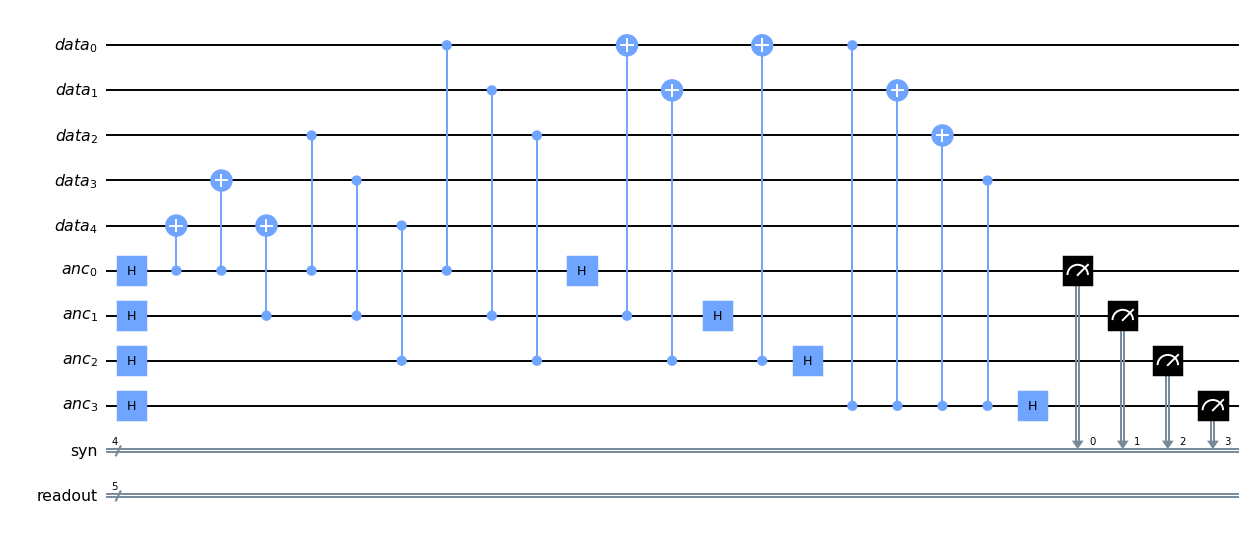

In [7]:
circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, syndrome_measure_reg, cdata_register)
# circuit.append(encoding(), qdata_register)
circuit.append(stabilizer_measurement(), [*qdata_register, *stabilizer_measure_reg], [*syndrome_measure_reg])
circuit.decompose().draw("mpl", scale=0.7, fold=60, plot_barriers=False)

In [8]:
def build_error_correction_sequence(look_up: dict, noisy_qubits, apply_correction = False, apply_fake_noise = None, code_distance = 3) -> QuantumCircuit:
    '''Build the error correction sequence'''    
    circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, syndrome_measure_reg, cdata_register)
    circuit = initialize_qubits(circuit, qdata_register[0])

    circuit.append(encoding(), qdata_register)
    circuit.barrier()
    
    if apply_fake_noise is not None:
        noise_type = apply_fake_noise
        circuit = fake_noise(circuit, qdata_register, code_distance, noise_type, noisy_qubits)

    circuit.append(stabilizer_measurement(), [*qdata_register, *stabilizer_measure_reg], [*syndrome_measure_reg])

    if apply_correction:
        circuit = recovery(circuit, qdata_register, syndrome_measure_reg, look_up)
    else:
        circuit.id(qdata_register)
        circuit.id(qdata_register)
        circuit.id(qdata_register)
        
    circuit.barrier()
    
    circuit.append(decoding(), qdata_register)

    circuit = final_readout(circuit, qdata_register, cdata_register)

    return circuit

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:1807: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


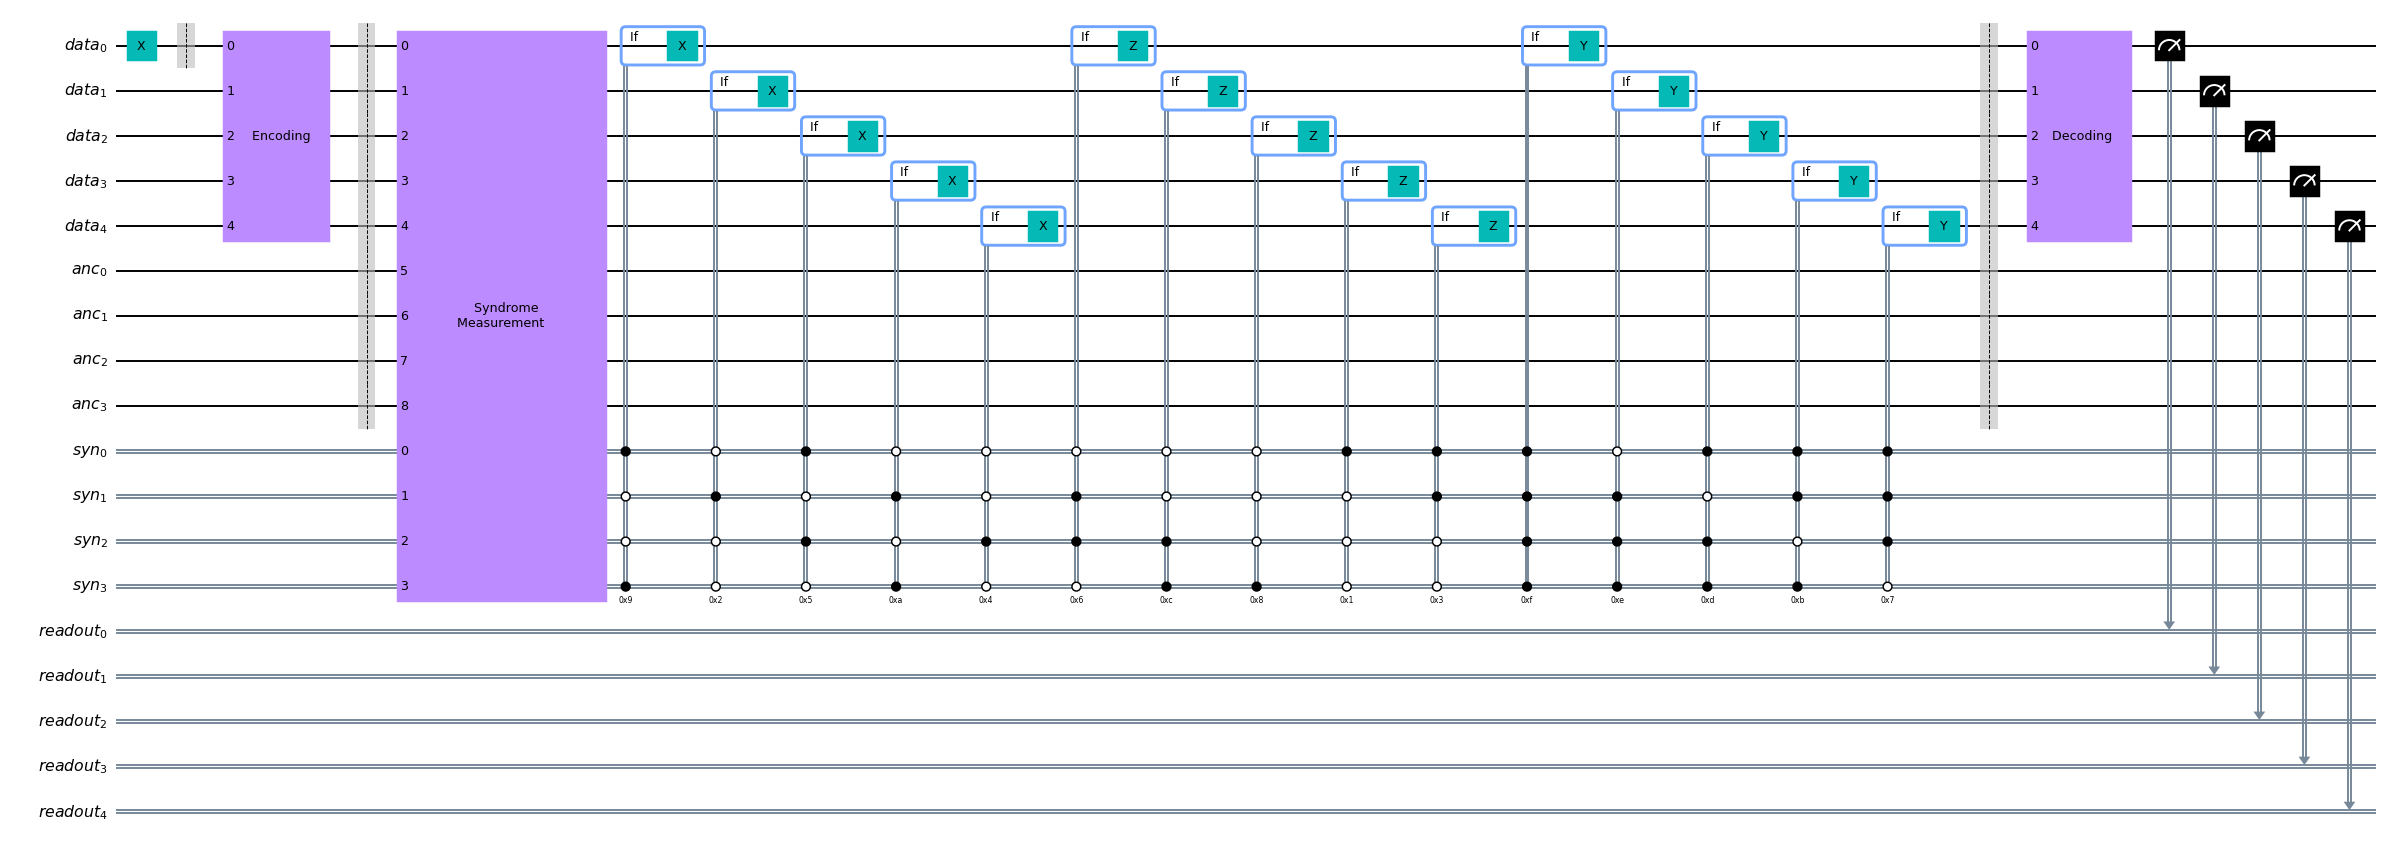

In [9]:
noisy_qubits = np.random.randint(len(qdata_register), size=(3 - 1)//2)
noise_ = None

circuit_with_correction = build_error_correction_sequence(recovery_look_up, noisy_qubits, apply_correction = True, apply_fake_noise= noise_)
circuit_without_correction = build_error_correction_sequence(recovery_look_up, noisy_qubits, apply_correction = False, apply_fake_noise= noise_)

circuit_with_correction.draw("mpl", plot_barriers=True, scale = 0.7, fold=60, cregbundle=True)

In [10]:
# circuit_with_correction.decompose().draw("mpl", scale=0.7, fold=60, plot_barriers=True)

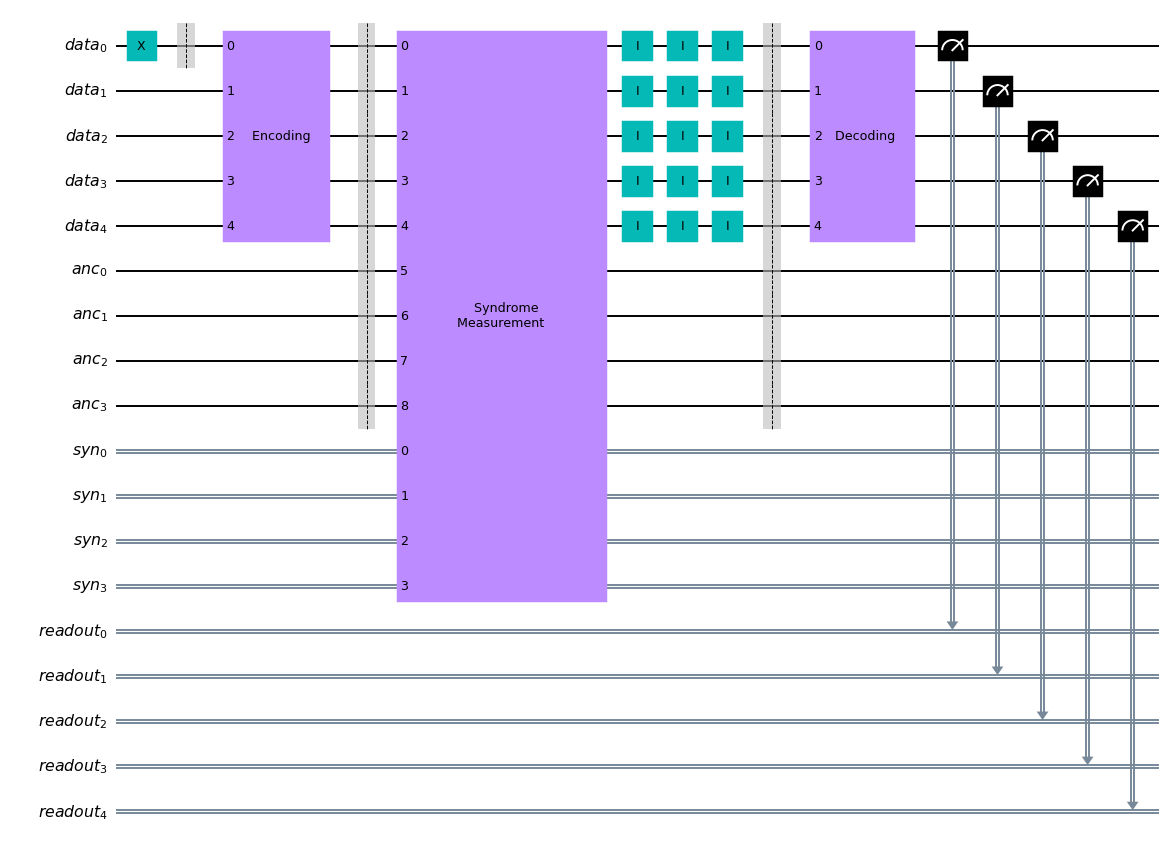

In [11]:
circuit_without_correction.draw("mpl", scale=0.7, fold=60, plot_barriers=True)

In [12]:
shots = 1024
# provider = IBMProvider()
# provider.backends()

In [13]:
# backend = least_busy(provider.backends(simulator=False, operational=True, dynamic_circuits = True))
# # provider.get_backend("ibmq_qasm_simulator")
# backend = provider.get_backend("ibm_kyoto")
# backend

In [14]:
import qiskit_aer.noise as noise
from qiskit.providers.fake_provider import FakeMontreal

backend = FakeMontreal()
noise_model = noise.NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# p_reset = 0.03
# p_meas = 0.1
# p_gate1 = 0.05

# QuantumError objects
# error_reset = noise.pauli_error([('X', p_reset), ('I', 1 - p_reset)])
# error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
# error_gate1 = noise.pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
# noise_bit_flip = noise.NoiseModel()
# noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
# noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["id"])

# # noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# noise_model = noise.NoiseModel()
# error = noise.depolarizing_error(0.05, 1)
# noise_model.add_quantum_error(error, ["id", "rz"], [1])

# # Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

# backend = AerSimulator(noise_model=noise_model)
# # backend = AerSimulator()

# print(noise_model)
# backend

In [15]:
correction_transpiled_circuit = transpile(circuit_with_correction, backend)
uncorrected_transpiled_circuit = transpile(circuit_without_correction, backend)
# correction_transpiled_circuit.draw(output="mpl", idle_wires=False, scale=0.5, fold=50)

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


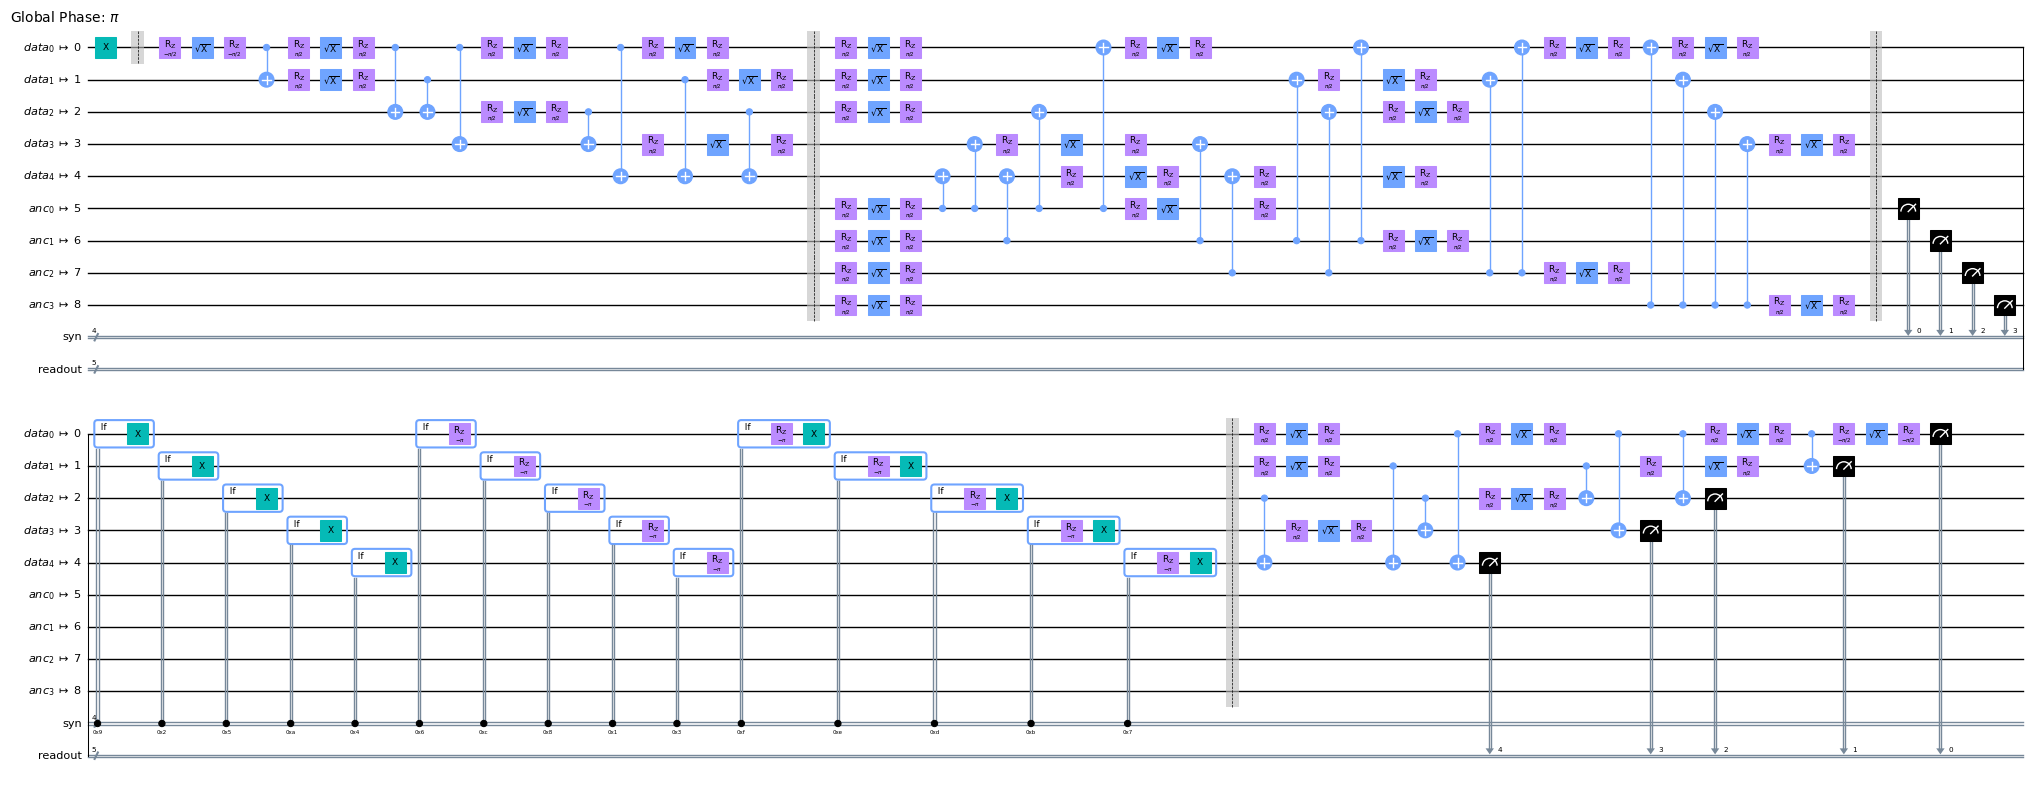

In [16]:
correction_transpiled_circuit.draw(output="mpl", scale=0.5, idle_wires=False, fold=60)

In [17]:
correction_transpiled_circuit.depth()

77

In [18]:
job_with_correction = backend.run(correction_transpiled_circuit, shots=shots, dynamic=True)
job_monitor(job_with_correction)

Job Status: job has successfully run


In [19]:
# import json
# from qiskit.result import Result

# f = open('./5_1_3/cnx83axwykr00085fgf0-result.txt')
# correction_data = json.load(f)

# result_with_correction = Result.from_dict(correction_data)

In [20]:
result_with_correction = job_with_correction.result()

In [21]:
job_without_correction = backend.run(uncorrected_transpiled_circuit, shots=shots, dynamic = True)
job_monitor(job_without_correction)

Job Status: job has successfully run


In [22]:
result_without_correction = job_without_correction.result()

In [23]:
initial_state = ['00001']
ideal_result = {'00001': shots}

In [24]:
syndrome_indices = list(range(len(syndrome_measure_reg)))
data_indices = list(range(syndrome_indices[-1]+1, len(qdata_register) + len(syndrome_measure_reg) ))

def decode_result(data_counts, syndrome_counts, initial_state):
    shots = sum(data_counts.values())
    success_trials = sum([data_counts.get(i, 0) for i in initial_state])
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('0000', 0)
    print(f"Errors were detected/corrected on {error_correction_events}/{shots} trials")
    print(f"A final error was detected on {failed_trials}/{shots} trials")

In [25]:
print("******************** Without Quantum Error Correction ********************\n")

non_corrected_marginalized_data_counts = marginal_counts(result_without_correction, data_indices).get_counts(0)
non_corrected_marginalized_syndrome_counts = marginal_counts(result_without_correction, syndrome_indices).get_counts(0)

print(f'Completed bit code experiment data measurement counts {non_corrected_marginalized_data_counts}')
print(f'Completed bit code experiment syndrome measurement counts {non_corrected_marginalized_syndrome_counts}')
decode_result(non_corrected_marginalized_data_counts, non_corrected_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, non_corrected_marginalized_data_counts)))

******************** Without Quantum Error Correction ********************

Completed bit code experiment data measurement counts {'01111': 2, '01011': 3, '10001': 12, '00010': 9, '00110': 4, '00000': 22, '00011': 101, '00001': 803, '11110': 3, '10100': 1, '01101': 3, '01001': 11, '01100': 3, '00111': 6, '00101': 19, '10111': 3, '11001': 1, '01010': 6, '00100': 3, '11010': 3, '10011': 2, '10110': 2, '01110': 1, '11100': 1}
Completed bit code experiment syndrome measurement counts {'1010': 8, '0010': 55, '0100': 41, '0101': 2, '1000': 14, '0110': 4, '1111': 5, '1100': 3, '0000': 870, '0001': 16, '1001': 4, '1011': 1, '1110': 1}
Errors were detected/corrected on 154/1024 trials
A final error was detected on 221/1024 trials

Fidelity: 0.7841796875


In [26]:
print("******************** With Quantum Error Correction ********************\n")

corrected_marginalized_data_counts = marginal_counts(result_with_correction, data_indices).get_counts(0)
corrected_marginalized_syndrome_counts = marginal_counts(result_with_correction, syndrome_indices).get_counts(0)

print(f'Completed bit code experiment data measurement counts {corrected_marginalized_data_counts}')
print(f'Completed bit code experiment syndrome measurement counts {corrected_marginalized_syndrome_counts}')
decode_result(corrected_marginalized_data_counts, corrected_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, corrected_marginalized_data_counts)))

******************** With Quantum Error Correction ********************

Completed bit code experiment data measurement counts {'00000': 34, '00010': 1, '10011': 1, '01100': 1, '01011': 6, '10001': 38, '00001': 794, '01000': 4, '01001': 27, '01111': 1, '00011': 78, '01110': 2, '00101': 13, '00111': 5, '01010': 5, '01101': 1, '00100': 5, '11010': 4, '11111': 1, '00110': 2, '10101': 1}
Completed bit code experiment syndrome measurement counts {'0011': 1, '0000': 864, '0100': 37, '0110': 6, '1011': 3, '1000': 17, '1111': 3, '0001': 15, '1101': 1, '1100': 6, '0010': 62, '1110': 2, '1010': 6, '0101': 1}
Errors were detected/corrected on 160/1024 trials
A final error was detected on 230/1024 trials

Fidelity: 0.7753906250000001
